# Performance optimization of a neural network for the food industry

GourmetAI Inc., a renowned food technology company, faces growing challenges in improving the accuracy and efficiency of food image classification systems. The need to provide customers with advanced, high-quality solutions to correctly identify and categorize foods is essential to improve user experience and optimize business processes.

**Project benefits:** the implementation of advanced deep learning techniques for food image classification offers numerous advantages:

* **Improved user experience:** a precise and reliable system significantly improves user experience in food image recognition applications, providing fast and accurate results.
* **Business process optimization:** automating image classification reduces the time and resources needed to identify and categorize foods, improving overall operational efficiency.
* **Technological innovation:** using advanced deep learning techniques promotes innovation within the company, enabling complex challenges in the image recognition industry.
* **Business objectives:** improving the performance of classification models helps GourmetAI Inc. meet business objectives, consolidating its position as a leader in the food technology sector.

**Project details:** GourmetAI Inc. has requested the development of an advanced food image classification model using deep learning techniques. The project will be based on the Food Classification dataset, enriched with augmentation techniques to improve the diversity and quality of the available data.

**Project objectives:**

1. **Augmentation strategies:** implement different augmentation techniques to enrich the dataset, improving data variability and quality.
2. **Dataset division:** Divide the dataset into trainsets, valsets and testsets to ensure adequate model training and validation.
3. **Network and transfer learning architectures:** select and implement one or more neural network architectures suitable for the problem, using transfer learning to exploit pre-trained models.
4. **Fine tuning and choice of hyperparameters:** create a custom classifier, choose hyperparameters and optimize the model through training and validation processes.
5. **Validation and regularization:** use validation techniques to improve the choice of hyperparameters and solve potential problems with regularization techniques.
6. **Final test:** perform a final test to verify the generalization capabilities of the model and achieve the desired performance.

**Project phases:**

* **Development of augmentation strategies:** exploration and implementation of augmentation techniques to enrich the dataset.
* **Dataset preparation:** division of the dataset into trainsets, valsets and testsets; preparation of tools for using images as input.
* **Selection and implementation of architectures:** choice and implementation of neural network architectures, applying transfer learning.
* **Fine tuning and choosing hyperparameters:** creating a custom classifier, selecting hyperparameters and optimizing the model.
* **Validation and regularization:** repetition of training with validation and regularization techniques to improve the performance of the model.
* **Final test:** performing a final test to evaluate the generalization capabilities of the model and compare the results with expectations.

**Project motivation:** for GourmetAI Inc., precision in the classification of food images represents a fundamental requirement. Improving the effectiveness of rating systems not only improves user experience and optimizes business processes, but also helps consolidate leadership in the food technology industry through technological innovation.

With this project, GourmetAI Inc. aims to develop and implement an advanced food image classification system, using cutting-edge deep learning techniques to achieve superior performance and meet specific market needs.

# Dataset

The dataset is available at the following link: https://proai-datasets.s3.eu-west-3.amazonaws.com/dataset_food_classification.zip

# Disclaimer

*Due to the extremely long training times of the models, it became necessary to implement a checkpoint saving system that would ensure their persistence when Google Colab sessions expired. To do this, we used the storage space offered by Google Drive. To take advantage of this feature, you need to connect your Google account and provide paths at runtime to save model checkpoints. This same approach also saved log and accuracy report information to ensure consistency between the models developed and the analysis of their statistics.*

# Environment set up

In [ ]:
# Library import
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights, resnet18, ResNet18_Weights
from sklearn.metrics import classification_report, confusion_matrix
from albumentations.pytorch import ToTensorV2
from torch.amp import autocast, GradScaler
import torchvision.models as models
from torchsummary import summary
from collections import Counter
import matplotlib.pyplot as plt
from google.colab import drive
import torch.optim as optim
import albumentations as A
import torch.nn as nn
import seaborn as sns
import numpy as np
import torchvision
import zipfile
import random
import torch
import json
import os

In [ ]:
# Mount Google Drive to access files and save models
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Seed set up to ensure reproducibility
seed = 0

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
# Check that the GPU is mounted correctly
torch.cuda.is_available()

True

In [ ]:
# Select the device to run PyTorch tensors and models on, preferring GPU (CUDA) if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Utilities

In [ ]:
# Utility function to convert a tensor back to a displayable image format
def back_to_image(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

The **Transform** class prepares data for the **Albumentations** module by converting it into NumPy arrays, enabling data augmentation methods, and then returning only the transformed images.

In [ ]:
# Transform class definition
class Transforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

The **EarlyStopping** class prevent overfitting by monitoring the model's performance on a validation set and stopping the training process if the performance on the validation set starts to degrade.

In [ ]:
class EarlyStopping:
    def __init__(self, save_model, save_log, patience=5, min_delta=0.01):

        self.save_model = save_model
        self.save_log = save_log
        self.patience = patience
        self.min_delta = min_delta
        self.min_val_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_epoch = 0

    def __call__(self, validation_loss, model, epoch, optimizer, scaler):

        # First epoch or improvement
        if self.min_val_loss is None or (self.min_val_loss - validation_loss) > self.min_delta:
            self.min_val_loss = validation_loss
            self.best_epoch = epoch
            self.save_checkpoint(model, epoch, optimizer, scaler)
            self.counter = 0

        # No improvements
        else:
            self.counter += 1
        if self.counter >= self.patience:
            self.early_stop = True

    # Save model training state
    def save_checkpoint(self, model, epoch, optimizer, scaler):
        model_state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'min_val_loss': self.min_val_loss,
            'counter': self.counter,
            'best_epoch': self.best_epoch,
            'patience': self.patience
            }
        torch.save(model_state, self.save_model)

    # Load model state when resuming training from a checkpoint
    def load_state(self, min_val_loss, counter, best_epoch, patience):
        self.min_val_loss = min_val_loss
        self.counter = counter
        self.best_epoch = best_epoch,
        self.patience = patience

The **train**, **train_epochs** and **test_epochs** functions work together to train and evaluate the neural network model, providing a structured approach to the training loop.

In [ ]:
# Train function (implements early stopping)
def train(model, train_loader, test_loader, criterion, optimizer, device, epochs=50, early_stopping=None):
    scaler = GradScaler() # Initialize GradScaler for mixed precision

    train_losses = []
    test_losses = []
    test_accuracies = []

    start_epoch = 0

    if early_stopping:
        # Load existing model (if available)
        if os.path.exists(early_stopping.save_model):
            checkpoint = torch.load(early_stopping.save_model)

            # Load model state
            model.load_state_dict(checkpoint['model_state_dict'])

            # Load optimizer and scaler states
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scaler.load_state_dict(checkpoint['scaler_state_dict'])

            # Load early stopping internal state
            early_stopping.load_state(
            checkpoint['min_val_loss'],
            checkpoint['counter'],
            checkpoint['best_epoch'],
            checkpoint['patience'])

            # Resume training from the next epoch
            start_epoch = checkpoint['epoch'] + 1

            # Load previous training history (if available)
            if os.path.exists(early_stopping.save_log):
                with open(early_stopping.save_log, 'r') as f:
                    log_data = json.load(f)
                    train_losses.extend(log_data.get('train_losses', []))
                    test_losses.extend(log_data.get('test_losses', []))
                    test_accuracies.extend(log_data.get('test_accuracies', []))

                # Restore train_losses, test_losses and test_accuracies to match the correct training epoch
                train_losses = train_losses[:start_epoch]
                test_losses = test_losses[:start_epoch]
                test_accuracies = test_accuracies[:start_epoch]

            # Print out old log informations and resume training
            print('Starting training...')
            for e in range(start_epoch):
                print(f'Epoch {e+1}/{epochs}\n- Train loss: {train_losses[e]:.4f}\n- Validation loss: {test_losses[e]:.4f}\n- Validation accuracy: {test_accuracies[e]:.4f}')
            print(f'\nResuming training from epoch {start_epoch+1}...')

        else:
            print('Starting training...')

    # Main training loop
    for epoch in range(start_epoch, epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
        test_loss, test_accuracy = test_epoch(model, test_loader, criterion, device)

        # Store and save training statistics
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        to_save_json = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'test_accuracies': test_accuracies
        }

        with open(early_stopping.save_log, 'w') as f:
            json.dump(to_save_json, f)

        print(f'Epoch {epoch+1}/{epochs}\n- Train loss: {train_loss:.4f}\n- Validation loss: {test_loss:.4f}\n- Validation accuracy: {test_accuracy:.4f}')

        # Trigger early stopping
        if early_stopping is not None:
            early_stopping(test_loss, model, epoch, optimizer, scaler)
            if early_stopping.early_stop:
                print('Early stopping triggered')
                break

    return train_losses, test_losses, test_accuracies

# Train function by epochs
def train_epoch(model, train_loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    processed_data = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        # Use autocast for mixed precision
        with autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        processed_data += len(inputs)

    return running_loss / processed_data

# Test function by epochs
def test_epoch(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

The **plot_confusion_matrix** function automates the process of getting predictions from the model on a given dataset, comparing them to the actual labels, calculating the confusion matrix, and visualizing it as a heatmap.

In [ ]:
# Utility function to display the confusion matrix
def plot_confusion_matrix(model, test_loader, device):

    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Greens')

# Data preparation

Let's start by downloading and importing the provided dataset and proceed with an initial exploratory analysis.

In [ ]:
# Download and import dataset
url = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/dataset_food_classification.zip'
zip_path = 'dataset_food_classification.zip'
extract_dir = 'food_dataset'

# Download the file if it does not exists
if not os.path.exists(zip_path):
    !wget {url} -O {zip_path}

# Extract the '.zip' file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

--2025-12-03 20:48:42--  https://proai-datasets.s3.eu-west-3.amazonaws.com/dataset_food_classification.zip
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 3.5.204.5, 3.5.205.112
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|3.5.204.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1072486271 (1023M) [application/zip]
Saving to: ‘dataset_food_classification.zip’

dataset_food_classi 100%[===================>]   1023M  16.4MB/s    in 65s     

2025-12-03 20:49:47 (15.8 MB/s) - ‘dataset_food_classification.zip’ saved [1072486271/1072486271]



The *train_transform* and *test_val_transform* variable applies data augmentation methods to the training data via *A.Resize*, *A.Normalize*, and *ToTensorV2* to increase data availability during model training. These specific methods are crucial because:

* **Fixed size:** neural networks require a consistent input size.
* **Normalization:** normalized data improves training stability and speed.
* **Pytorch tensors**: pytorch models only accept *tensors* as input.

In [ ]:
# Data augmentation
train_transform = A.Compose([

    # Spatial diversity
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
    A.ElasticTransform(alpha=1, sigma=50, p=0.5),
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.05), rotate=(-15, 15), p=0.5),
    A.RandomBrightnessContrast(p=0.1),
    A.HueSaturationValue(p=0.1),
    A.Transpose(),

    A.Resize(256, 256),
    A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

    ToTensorV2()
])

In [ ]:
# Define transformations for the test and validation data
test_val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ToTensorV2()
])

The next step is to prepare the dataset for training, validation, and testing. This involves splitting the dataset into three distinct sets: a **training set** (for model training), a **validation set** (for tuning hyperparameters and preventing overfitting), and a **test set** (for evaluating the final model's performance on unseen data). At the same time we apply the transformations on the various datasets.

In [ ]:
# Load datasets from the specified directory and apply the defined transformations
base_url = '/content/food_dataset/dataset/'

trainset = torchvision.datasets.ImageFolder(
    root=f'{base_url}train',
    transform=Transforms(train_transform))

valset = torchvision.datasets.ImageFolder(
    root=f'{base_url}val',
    transform=Transforms(test_val_transform))

testset = torchvision.datasets.ImageFolder(
    root=f'{base_url}test',
    transform=Transforms(test_val_transform))

Basic checks are carried out on the created datasets.

In [ ]:
# Check the shape of the image tensor in the training set
trainset[0][0].shape

torch.Size([3, 256, 256])

In [ ]:
# Check the number of samples in each dataset (train, validation, and test)
len(trainset), len(valset), len(testset)

(8960, 2240, 2800)

In [ ]:
# Number and list of class names from the training dataset
classes = trainset.classes
print(len(classes), classes)

14 ['Baked Potato', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Sandwich', 'Taco', 'Taquito', 'apple_pie', 'cheesecake', 'chicken_curry', 'ice_cream', 'omelette', 'sushi']


Let's displaying some images after applying data augmentation.

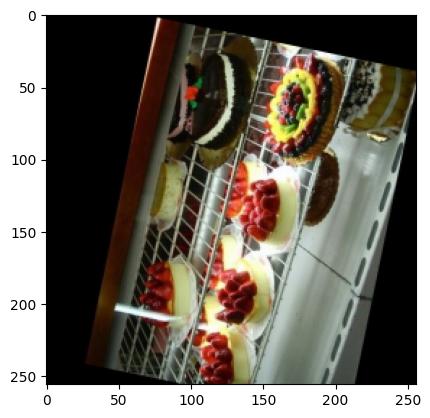

In [ ]:
# Display an image from the training set after applying transformations
image = back_to_image(trainset[random.randint(0, len(trainset))][0])
plt.imshow(image)
plt.show()

Let's now look at a sample of images from the training dataset.

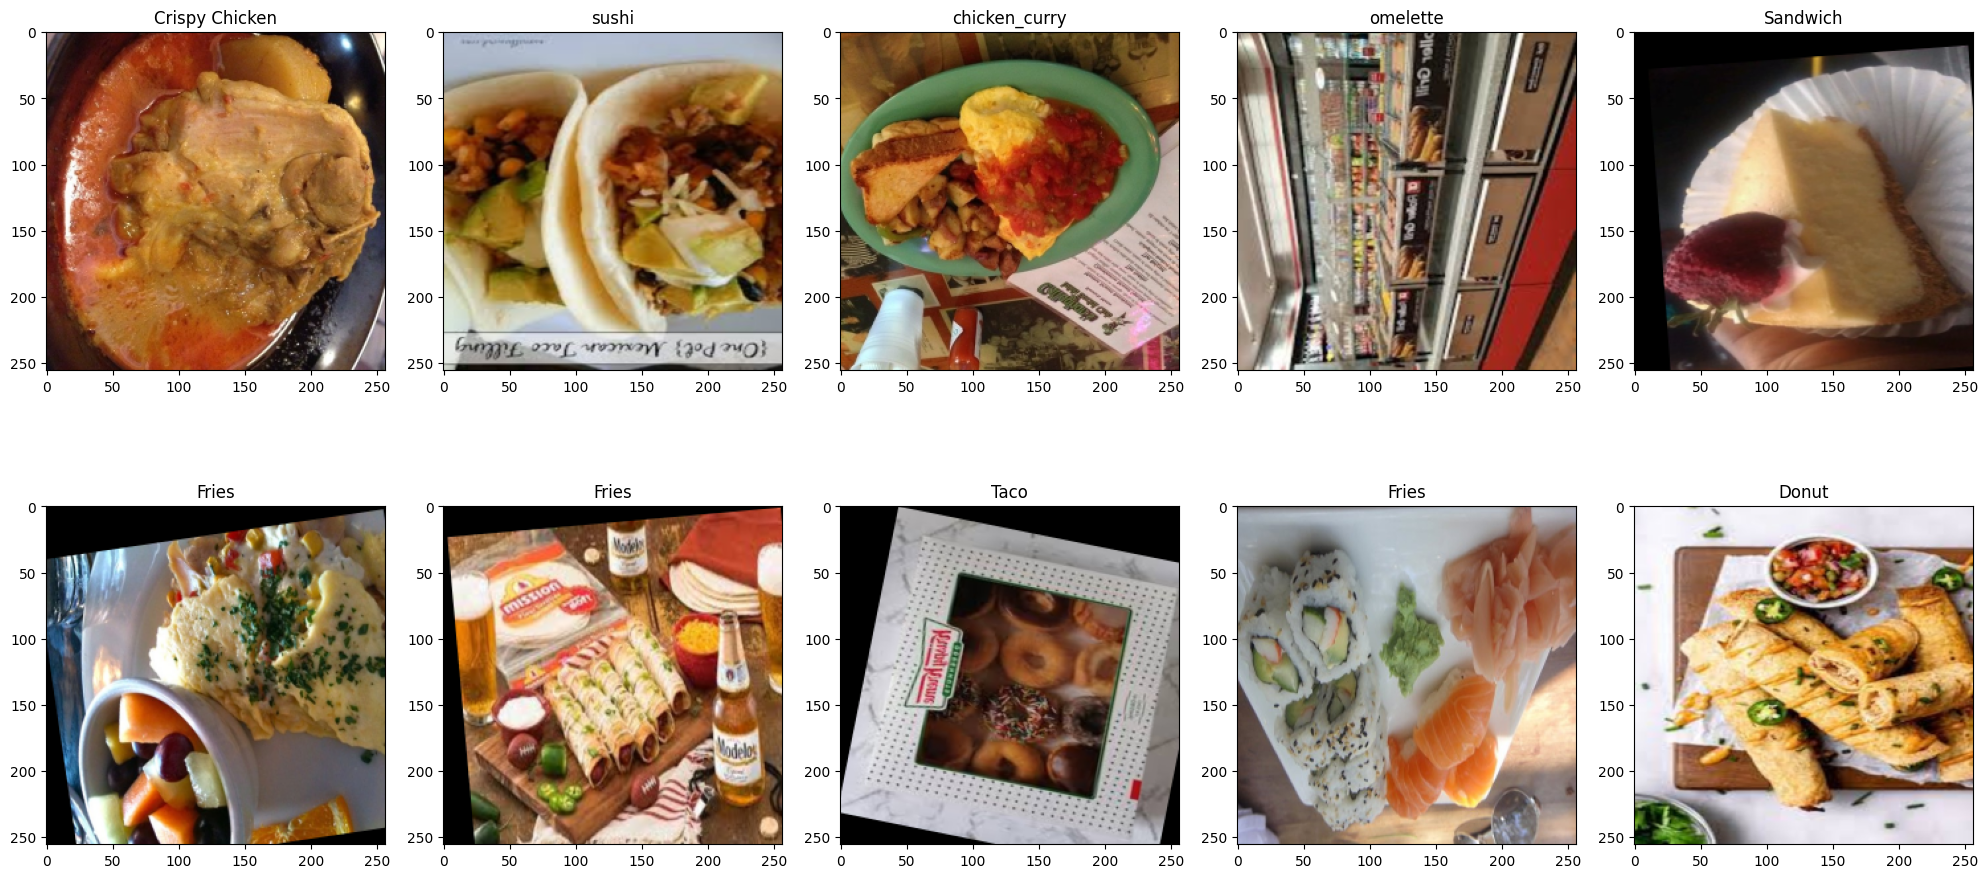

In [ ]:
# Display a sample of images from the training dataset with their class names
classes = trainset.classes

num_row = 2
num_col = 5

fig, axes = plt.subplots(num_row, num_col, figsize = (10 * num_row, 2 * num_col))

for i in range(num_row * num_col):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(back_to_image(trainset[random.randint(0, len(trainset)) + i][0]))
    ax.set_title('{}'.format(classes[int(trainset[random.randint(0, len(trainset)) + i][1])]))

plt.tight_layout()
plt.show()

# Model implementation and training

To build the network we test two distinct architectures: **ResNet18** and **EfficientNet-B0**.

## ResNet18

**[ResNet18](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)** is a powerful yet compact image classification model that was revolutionary for using "skip connections" to efficiently train very deep neural networks.

In [ ]:
# Load the pre-trained ResNet18 model
resnet = models.resnet18(weights = models.ResNet18_Weights.DEFAULT).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 236MB/s]


In [ ]:
# Display the structure of the network
summary(resnet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [ ]:
# Customize the model
class ResNetClassifier(nn.Module):
    def __init__(self, model_backbone, num_classes, freeze_backbone=True):
        super().__init__()

        self.features = nn.Sequential(*list(model_backbone.children())[:-2])    # [N, 512, 8, 8]
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))                             # [N, 512, 1, 1]

        # Freeze weights
        if freeze_backbone:
            for param in self.features.parameters():
                param.requires_grad = False

        # New classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),                # [N, 512]
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, len(classes))
        )

    # Append new layer to the network
    def forward(self, x):
        x = self.features(x)            # [N, 512, 8, 8]
        x = self.pooling(x)             # [N, 512, 1, 1]
        x = self.classifier(x)          # [N, 14]
        return x

In [ ]:
resnet = ResNetClassifier(resnet, num_classes=len(classes), freeze_backbone=True).to(device)

In [ ]:
# Display the structure of the network
summary(resnet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [ ]:
# Set up directories to save the trained model and training logs
resnet_save_folder = '/content/drive/MyDrive/Projects/ProfessionAI - AI Engineering/Course 6 - Performance optimization of a neural network for the food industry/models/ResNet/'
os.makedirs(resnet_save_folder, exist_ok = True)
resnet_save_file = os.path.join(resnet_save_folder, 'model.pt')
resnet_save_log = os.path.join(resnet_save_folder, 'model_log.json')

In [ ]:
# Define the loss function, optimizer, and early stopping
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr = 0.001)
early_stopping = EarlyStopping(resnet_save_file, resnet_save_log, patience = 5, min_delta = 0)
epochs = 50

In [ ]:
# Create data loaders for the training, validation, and test sets
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = 128,
                                          shuffle = True)

valloader = torch.utils.data.DataLoader(valset,
                                        batch_size = 128,
                                        shuffle = False)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size = 128,
                                         shuffle = False)

In [ ]:
# Training the model on the training data and validating on the validation data
train_losses, test_losses, test_accuracies = train(
    resnet, trainloader, valloader, criterion, optimizer, device, epochs, early_stopping
)

## EfficientNet-B0

**[EfficientNet-B0](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html)** is the smallest, baseline version of a modern neural network architecture that achieves high accuracy while being highly parameter and computationally efficient for image classification by using a technique called compound scaling.

In [ ]:
# Load the pre-trained EfficientNet-B0 model
effnet = models.efficientnet_b0(weights = EfficientNet_B0_Weights.DEFAULT).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 206MB/s]


In [ ]:
# Display the structure of the network
summary(effnet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              SiLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              SiLU-6         [-1, 32, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]             512
      BatchNorm2d-14         [-1, 16, 1

In [ ]:
# Customize the model
class EfficientNetClassifier(nn.Module):
    def __init__(self, model_backbone, num_classes, freeze_backbone=True):
        super().__init__()

        self.features = nn.Sequential(*list(model_backbone.children())[:-2])    # [N, 1280, 8, 8]
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))                             # [N, 1280, 1, 1]

        # Freeze weights
        if freeze_backbone:
            for param in self.features.parameters():
                param.requires_grad = False

        # New classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),                # [N, 1280]
            nn.Linear(1280, len(classes))
        )

    # Append new layer to the network
    def forward(self, x):
        x = self.features(x)            # [N, 1280, 8, 8]
        x = self.pooling(x)             # [N, 1280, 1, 1]
        x = self.classifier(x)          # [N, 14]
        return x

In [ ]:
effnet = EfficientNetClassifier(effnet, num_classes=len(classes), freeze_backbone=True).to(device)

In [ ]:
# Display the adapted structure of the network using torchsummary
summary(effnet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              SiLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              SiLU-6         [-1, 32, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]             512
      BatchNorm2d-14         [-1, 16, 1

In [ ]:
# Set up directories to save the trained model and training logs
effnet_save_folder = '/content/drive/MyDrive/Projects/ProfessionAI - AI Engineering/Course 6 - Performance optimization of a neural network for the food industry/models/EfficientNet/'
os.makedirs(effnet_save_folder, exist_ok = True)
effnet_save_file = os.path.join(effnet_save_folder, 'model.pt')
effnet_save_log = os.path.join(effnet_save_folder, 'model_log.json')

In [ ]:
# Define the loss function, optimizer, and early stopping
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnet.parameters(), lr = 0.001)
early_stopping = EarlyStopping(effnet_save_file, effnet_save_log, patience = 5, min_delta = 0)
epochs = 50

In [ ]:
# Create data loaders for the training, validation, and test sets
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = 128,
                                          shuffle = True)

valloader = torch.utils.data.DataLoader(valset,
                                        batch_size = 128,
                                        shuffle = False)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size = 128,
                                         shuffle = False)

In [ ]:
# Training the model on the training data and validating on the validation data
train_losses, test_losses, test_accuracies = train(
    effnet, trainloader, valloader, criterion, optimizer, device, epochs, early_stopping
)

# Performace evaluation

Let's have a look at the model performace on the validation dataset.

## ResNet18

In [ ]:
# Evaluate the models on the validation set
resnet_val_loss, resnet_val_accuracy = test_epoch(resnet, valloader, criterion, device)

print(f'Loss and accuracy of ResNet model on validation set: {resnet_val_loss}, {resnet_val_accuracy}')

Loss and accuracy of ResNet model on validation set: 0.004657744669488498, 0.8058035714285714


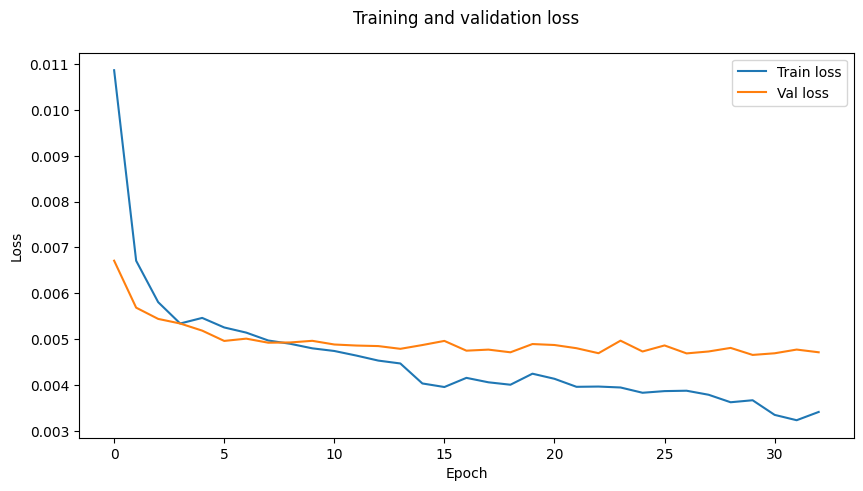

In [ ]:
# Visualize the training and validation loss over epochs
with open(resnet_save_log, 'r') as f:
    resnet_save_log_data = json.load(f)

plt.figure(figsize=(10, 5))
plt.plot(resnet_save_log_data['train_losses'], label='Train loss')
plt.plot(resnet_save_log_data['test_losses'], label='Val loss')
plt.title('Training and validation loss\n')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

As shown in the graph, around **epoch 10**, both losses begin to level off, meaning the model is approaching its optimal performance point. After that point, the *train loss* continues to slowly decrease, while the *val loss* plateaus and even shows slight increases and decreases. This suggests a degree of **overfitting**.

## EfficientNet-B0

In [ ]:
# Evaluate the models on the validation set
effnet_val_loss, effnet_val_accuracy = test_epoch(effnet, valloader, criterion, device)

print(f'Loss and accuracy of EfficientNet model on validation set: {effnet_val_loss}, {effnet_val_accuracy}')

Loss and accuracy of EfficientNet model on validation set: 0.004321811441332102, 0.8241071428571428


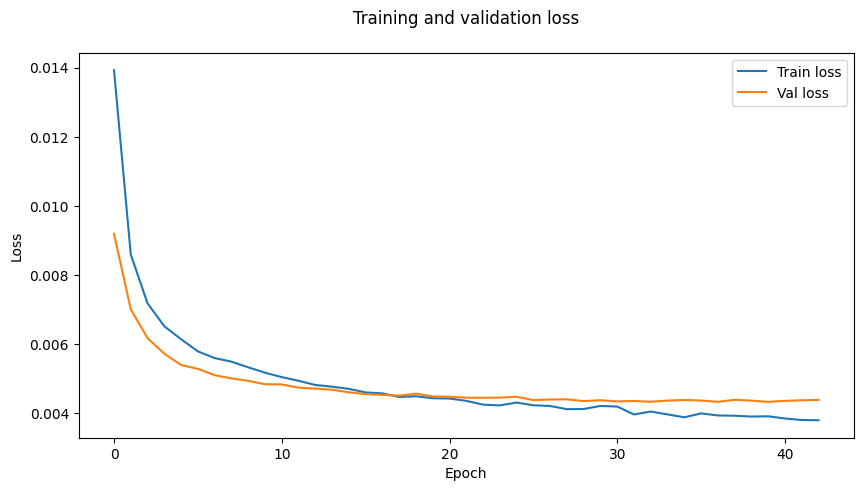

In [ ]:
# Visualize the training and validation loss over epochs
with open(effnet_save_log, 'r') as f:
    effnet_save_log_data = json.load(f)

plt.figure(figsize=(10, 5))
plt.plot(effnet_save_log_data['train_losses'], label='Train loss')
plt.plot(effnet_save_log_data['test_losses'], label='Val loss')
plt.title('Training and validation loss\n')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In this case, unlike the previous graph, the *val loss* is consistently lower than the *train loss* for the entire duration of the training. Crucially, the lines track each other very closely and neither line diverges significantly, meaning the model is generalizing very well and not overfitting.
After about **epoch 20**, both loss curves flatten out significantly. This indicates the model has largely converged and further training is providing minimal, if any, performance gain.

The **EfficientNet-B0** model shows **superior generalization** because its validation loss is not only very close to the training loss but actually slightly lower. This indicates that it learned the core problem very well without specializing too much on the training data noise.

The **ResNet18** model exhibited a small, yet clear sign of overfitting, which suggests it was starting to "memorize" the training data details that don't apply to new data.

While the EfficientNet-B0 took a bit longer to reach its ultimate plateau (epoch 20-25 vs. 10-15 for ResNet18), it ultimately converged to a lower final loss value on the validation set, suggesting it found a slightly better overall solution.

In short, the EfficientNet-B0 training session appears **healthier and more robust** based on these loss curves, as it achieved a lower validation error while showing better generalization.

# Display of results

Finally, let's check the results achieved on the test dataset.

## ResNet18

Text(95.58159722222221, 0.5, 'Actual value')

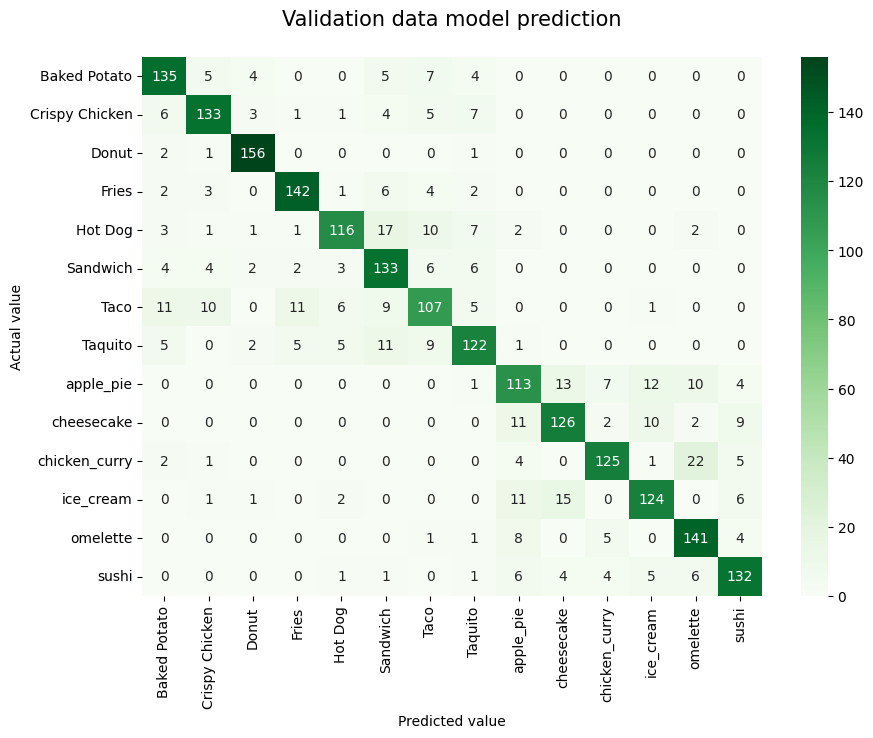

In [ ]:
# Display the confusion matrix for the validation set
plot_confusion_matrix(resnet, valloader, device)
plt.title('Validation data model prediction\n', size=15)
plt.xlabel('Predicted value')
plt.ylabel('Actual value')

As shown by the confusion matrix, the best performing classes are *Baked Potato* (135), *Donut* (156), *Taquito* (122), *Omelette* (141), and *Sushi* (132).

The misclassified instances show where the model is struggling.

* *Hot Dog*: this class has the most noticeable misclassifications:
    - 17 were misclassified as *Sandwich*.
    - 10 were misclassified as *Taco*.

    116 were correctly identified, but the high number of errors suggests visual similarity problems, perhaps because the images contain similar components (bread, fillings, toppings).

* *Sandwich*: this class is also prone to confusion:
    - 9 were misclassified as *Taco*.
    - 6 were misclassified as *Hot Dog*.

* *Taco* and *Taquito*: there is some confusion, though the model is generally correct for both:
    - 10 actual *Taco* were misclassified as *Taquito*.
    - 11 actual *Taquito* were misclassified as *Taco*.
    
    This is expected, as these items are often visually similar (tortilla-based, rolled or folded).

* *Dessert* confusion: there's noticeable confusion among the desserts:
    - 12 actual *Apple Pie* were misclassified as *Cheesecake*.
    - 11 actual *Cheesecake* were misclassified as *Ice Cream*.

## EfficientNet-B0

Text(95.58159722222221, 0.5, 'Actual value')

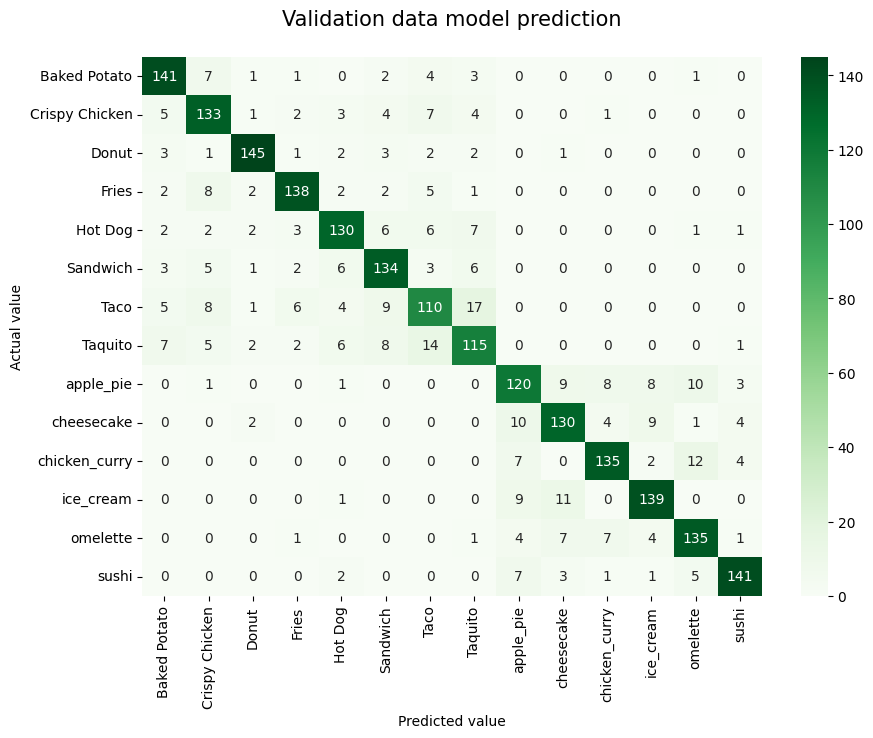

In [ ]:
# Display the confusion matrix for the validation set
plot_confusion_matrix(effnet, valloader, device)
plt.title('Validation data model prediction\n', size=15)
plt.xlabel('Predicted value')
plt.ylabel('Actual value')

The model excels at identifying *Baked Potato*, *Donut*, *Omelette*, *Sushi*.

While the overall performance is excellent, the off-diagonal numbers highlight specific classes that confuse the model.

* *Taco*/*Taquito* confusion: this is a significant point of confusion, which is common given their visual similarity (tortilla-based, often rolled).
    - 17 actual *Tacos* were incorrectly predicted as *Taquito*.
    - 14 actual *Taquito* were incorrectly predicted as *Taco*.
    
    This is the largest misclassification block in the entire matrix.

* *Sandwich*/*Taco* confusion:
    - 17 actual *Sandwiches* were misclassified as *Taco*. This suggests the model is focusing on tortilla/filling-like visual cues rather than bread/bun structure.
    
* *Hot Dog* confusion: this class still shows issues, though different from the last matrix:
    - 13 were misclassified as *Sandwich*.
    - 10 were misclassified as *Taco*.

* *Dessert* confusion (*Ice Cream*):
    - 11 actual *Cheesecake* were misclassified as *Ice Cream*.
    - 10 actual *Apple Pie* were misclassified as *Ice Cream*.

    This suggests the visual texture or white/creamy appearance might be leading to errors in the dessert category.

# Conclusions

This project involved training and evaluating two Convolutional Neural Network (CNN) architectures, **ResNet18** and **EfficientNet-B0**, for food image classification, followed by an in-depth analysis of their loss curves and confusion matrices to guide performance optimization.

---

## 1. Training performance assessment

Based on the training and validation loss curves, the **EfficientNet-B0** model exhibited the most robust and generalizable performance:

* **EfficientNet-B0**: the model showed excellent convergence, with the validation loss tracking the training loss very closely and consistently settling at a **lower final value**. This is a strong indicator of **high generalization capability** and minimal overfitting. The ideal stopping point was around **epoch 20-25**.

* **ResNet18**: this model showed a clear, though mild, sign of **overfitting**, indicated by the slight divergence after epoch 10, where the training loss continued to drop while the validation loss began to plateau. The final validation loss was also slightly higher.

---

## 2. Classification accuracy and misclassification analysis

Analysis of the confusion matrices confirmed that both models achieved a **high overall accuracy**, effectively classifying a majority of the food items. However, they highlighted specific areas of confusion that require targeted improvement:

* **Systematic confusion**: both models struggled with visually similar classes, most notably the pairs:
    - **Taco/Taquito**: the EfficientNet-Bo model showed the greatest difficulty here, with 17 actual Tacos misclassified as Taquitos. This highlights an inherent visual challenge in distinguishing between the two forms (folded vs. rolled tortillas).
    - **Hot Dog/Sandwich**: both models showed significant confusion, though the second model was slightly better at separating *Hot Dog* from *Sandwich*, while the first model was better at the *Sandwich* - *Taco* distinction.

* **Identified errors**: the off-diagonal errors pinpointed specific misclassifications (e.g., desserts like *Apple Pie* and *Cheesecake* confused with *Ice Cream*), suggesting the model may be focusing on high-level features like texture or color rather than structure for these specific instances.

---

## 3. Final recommendation

The **EfficientNet-B0** is the preferred model architecture for this task due to its **better generalization** and **lower final validation loss**.

To achieve a production-ready model, is recommended to focus resources on gathering more diverse, fine-grained images or applying **specialized data augmentation** to the most confused class pairs (*Taco*/*Taquito*, *Sandwich*/*Taco*) to help the model learn the subtle visual differences that differentiate them.